## Small Model Using Custom ResNet Architecture Trained On QuickDraw Dataset

- Trained on 5000 images per class for 30 classes 
- Accuracy - 60%

In [ ]:
import os
import numpy as np
from urllib.request import urlretrieve
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# List of classes
classes = ['Airplane', 'Apple', 'Bicycle', 'Book', 'Car', 'Cat', 'Chair', 'Clock', 'Dog', 'Door', 'Eye', 'Fish', 'Flower', 'Fork', 'House', 'Key', 'Ladder', 'Moon', 'Mountain', 'Pizza', 'Rainbow', 'Shoe', 'Smiley Face', 'Star', 'Stop Sign', 'Sun', 'Table', 'Tennis Racquet', 'Tree', 'Wheel']

# Base URL for downloading
base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"

def download_data(class_name):
    url = base_url + class_name.replace(' ', '%20') + '.npy'
    path = f'{class_name}.npy'
    if not os.path.exists(path):
        urlretrieve(url, path)
    return np.load(path, allow_pickle=True)

def load_data(className):
    return np.load(f'{className}.npy')

# Directory to save the downloaded files
output_dir = "quickdraw_data_npy"   
os.makedirs(output_dir, exist_ok=True)

# Loop through each class
for class_name in classes:
    try:
        print(f"Downloading {class_name}...")
        data = download_data(class_name.lower())
        print(f"Loaded data for {class_name}, shape: {data.shape}")
    except Exception as e:
        print(f"Failed to process {class_name}: {e}")

print("All downloads complete.")


In [ ]:
# Configuration
NUM_CLASSES = 30
IMG_SIZE = (28, 28)
BATCH_SIZE = 128 
EPOCHS = 100
TEST_SIZE = 0.2

In [ ]:
# Data Loading and Preparation -------------------------------------------------
def load_and_preprocess_data(class_names):
    """Load and preprocess data from .npy files"""
    X, y = [], []
    for class_idx, name in enumerate(class_names):
        data = np.load(f"{name.lower()}.npy")[:5000]
        X.append(data.reshape(-1, *IMG_SIZE))  # Reshape to 28x28
        y.append(np.full(len(data), class_idx))
    
    X = np.concatenate(X)
    y = np.concatenate(y)
    
    # Split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=42
    )
    
    # Add channel dimension and normalize
    X_train = np.expand_dims(X_train, -1).astype('float32') / 255.0
    X_test = np.expand_dims(X_test, -1).astype('float32') / 255.0
    
    return X_train, X_test, y_train, y_test

class_names = ['Airplane', 'Apple', 'Bicycle', 'Book', 'Car', 'Cat', 'Chair', 'Clock', 'Dog', 'Door', 'Eye', 'Fish', 'Flower', 'Fork', 'House', 'Key', 'Ladder', 'Moon', 'Mountain', 'Pizza', 'Rainbow', 'Shoe', 'Smiley Face', 'Star', 'Stop Sign', 'Sun', 'Table', 'Tennis Racquet', 'Tree', 'Wheel']
X_train, X_test, y_train, y_test = load_and_preprocess_data(class_names)

X_train = X_train.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)


In [4]:
# Data Augmentation -----------------------------------------------------------
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    shear_range=0.15,
    fill_mode='constant',
    horizontal_flip=True,
    vertical_flip=True
)

In [5]:
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [10]:
# Enhanced Model Architecture -------------------------------------------------
def build_enhanced_cnn():
    inputs = layers.Input(shape=(*IMG_SIZE, 1))
    
    # Initial Convolutional Blocks
    x = layers.Conv2D(64, (3,3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(2)(x)
    
    # Residual Blocks
    def res_block(x, filters):
        shortcut = x
        x = layers.Conv2D(filters, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        return layers.Add()([shortcut, x])
    
    x = res_block(x, 64)
    x = layers.MaxPool2D(2)(x)
    x = res_block(x, 64)
    x = layers.GlobalAvgPool2D()(x)
    
    # Dense Head
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    return models.Model(inputs, outputs)

model = build_enhanced_cnn()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 28, 28,    │        640 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 14, 14,    │          0 │ re_lu_11[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 14, 14,    │     36,928 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 14, 14,    │     36,928 │ re_lu_12[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 14, 14,    │          0 │ max_pooling2d_7[… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 7, 7, 64)  │          0 │ add_7[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 7, 7, 64)  │     36,928 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_13 (ReLU)     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 7, 7, 64)  │     36,928 │ re_lu_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 7, 7, 64)  │          0 │ max_pooling2d_8[

 Total params: 321,950 (1.23 MB)

 Trainable params: 321,310 (1.23 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Training Setup --------------------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    callbacks.EarlyStopping(
        patience=15, 
        restore_best_weights=True,
        monitor='val_accuracy',
        min_delta=0.001
    ),
    callbacks.ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_accuracy'
    ),
    callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    callbacks.CSVLogger('training_log.csv')
]


In [13]:
# Training ---------------------------------------------------------------------
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


/home/arnav/.cache/pypoetry/virtualenvs/test-qnl_lgol-py3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745330367.643150    6924 service.cc:152] XLA service 0x7f90a40193c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745330367.643240    6924 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-04-22 19:29:27.768915: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745330368.387329    6924 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/937 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.0274 - loss: 3.7309 

I0000 00:00:1745330378.511013    6924 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


516/937 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.0417 - loss: 3.5698

2025-04-22 19:29:56.978567: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2302', 12 bytes spill stores, 12 bytes spill loads

2025-04-22 19:29:57.720104: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2527', 4 bytes spill stores, 4 bytes spill loads



936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0508 - loss: 3.5008

2025-04-22 19:30:19.796643: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_183_0', 44 bytes spill stores, 44 bytes spill loads

2025-04-22 19:30:20.679180: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_183', 484 bytes spill stores, 484 bytes spill loads

2025-04-22 19:30:26.774809: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_183', 52 bytes spill stores, 52 bytes spill loads



937/937 ━━━━━━━━━━━━━━━━━━━━ 65s 54ms/step - accuracy: 0.0508 - loss: 3.5005 - val_accuracy: 0.1172 - val_loss: 3.0601 - learning_rate: 1.0000e-05
Epoch 2/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.1016 - loss: 3.2103

/home/arnav/.cache/pypoetry/virtualenvs/test-qnl_lgol-py3.12/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1016 - loss: 3.2103 - val_accuracy: 0.1174 - val_loss: 3.0593 - learning_rate: 1.0000e-05
Epoch 3/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1334 - loss: 3.0543

937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.1335 - loss: 3.0542 - val_accuracy: 0.1686 - val_loss: 2.8460 - learning_rate: 1.0000e-05
Epoch 4/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1484 - loss: 2.9066 - val_accuracy: 0.1685 - val_loss: 2.8465 - learning_rate: 1.0000e-05
Epoch 5/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1868 - loss: 2.7905

937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.1868 - loss: 2.7904 - val_accuracy: 0.1889 - val_loss: 2.8417 - learning_rate: 1.0000e-05
Epoch 6/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2188 - loss: 2.6980 - val_accuracy: 0.1886 - val_loss: 2.8440 - learning_rate: 1.0000e-05
Epoch 7/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2222 - loss: 2.6433

937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.2222 - loss: 2.6432 - val_accuracy: 0.2053 - val_loss: 2.8415 - learning_rate: 1.0000e-05
Epoch 8/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2188 - loss: 2.6442 - val_accuracy: 0.2049 - val_loss: 2.8453 - learning_rate: 1.0000e-05
Epoch 9/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2586 - loss: 2.5174

937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.2586 - loss: 2.5174 - val_accuracy: 0.2223 - val_loss: 2.7207 - learning_rate: 1.0000e-05
Epoch 10/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3047 - loss: 2.3994 - val_accuracy: 0.2216 - val_loss: 2.7275 - learning_rate: 1.0000e-05
Epoch 11/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2920 - loss: 2.3998

937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.2921 - loss: 2.3998 - val_accuracy: 0.2315 - val_loss: 2.6816 - learning_rate: 1.0000e-05
Epoch 12/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.3281 - loss: 2.3516

937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3281 - loss: 2.3516 - val_accuracy: 0.2316 - val_loss: 2.6831 - learning_rate: 1.0000e-05
Epoch 13/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3170 - loss: 2.3044

937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.3171 - loss: 2.3044 - val_accuracy: 0.2670 - val_loss: 2.5162 - learning_rate: 1.0000e-05
Epoch 14/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3359 - loss: 2.3607 - val_accuracy: 0.2662 - val_loss: 2.5209 - learning_rate: 1.0000e-05
Epoch 15/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3493 - loss: 2.2023

937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.3493 - loss: 2.2023 - val_accuracy: 0.3088 - val_loss: 2.3436 - learning_rate: 1.0000e-05
Epoch 16/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.4219 - loss: 2.2008

937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4219 - loss: 2.2008 - val_accuracy: 0.3094 - val_loss: 2.3424 - learning_rate: 1.0000e-05
Epoch 17/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3785 - loss: 2.0996

937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - accuracy: 0.3785 - loss: 2.0996 - val_accuracy: 0.3771 - val_loss: 2.1412 - learning_rate: 1.0000e-05
Epoch 18/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3047 - loss: 2.2120 - val_accuracy: 0.3767 - val_loss: 2.1435 - learning_rate: 1.0000e-05
Epoch 19/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.4068 - loss: 2.0027 - val_accuracy: 0.3696 - val_loss: 2.1843 - learning_rate: 1.0000e-05
Epoch 20/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4609 - loss: 2.0202 - val_accuracy: 0.3705 - val_loss: 2.1778 - learning_rate: 1.0000e-05
Epoch 21/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4285 - loss: 1.9289

937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.4285 - loss: 1.9289 - val_accuracy: 0.4189 - val_loss: 1.9833 - learning_rate: 1.0000e-05
Epoch 22/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4844 - loss: 1.6977 - val_accuracy: 0.4186 - val_loss: 1.9867 - learning_rate: 1.0000e-05
Epoch 23/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - accuracy: 0.4499 - loss: 1.8570 - val_accuracy: 0.4086 - val_loss: 2.0165 - learning_rate: 1.0000e-05
Epoch 24/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5000 - loss: 1.6960 - val_accuracy: 0.4087 - val_loss: 2.0140 - learning_rate: 1.0000e-05
Epoch 25/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4698 - loss: 1.7985

937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.4698 - loss: 1.7984 - val_accuracy: 0.4398 - val_loss: 1.8897 - learning_rate: 1.0000e-05
Epoch 26/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.4297 - loss: 1.8797

937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4297 - loss: 1.8797 - val_accuracy: 0.4404 - val_loss: 1.8874 - learning_rate: 1.0000e-05
Epoch 27/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4872 - loss: 1.7400

937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.4872 - loss: 1.7400 - val_accuracy: 0.4485 - val_loss: 1.8475 - learning_rate: 1.0000e-05
Epoch 28/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.4453 - loss: 1.8742

937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4453 - loss: 1.8742 - val_accuracy: 0.4499 - val_loss: 1.8432 - learning_rate: 1.0000e-05
Epoch 29/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5029 - loss: 1.6844

937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.5029 - loss: 1.6844 - val_accuracy: 0.4513 - val_loss: 1.8407 - learning_rate: 1.0000e-05
Epoch 30/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 1:00 64ms/step - accuracy: 0.4453 - loss: 1.8334

937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4453 - loss: 1.8334 - val_accuracy: 0.4523 - val_loss: 1.8380 - learning_rate: 1.0000e-05
Epoch 31/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5141 - loss: 1.6451

937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.5141 - loss: 1.6451 - val_accuracy: 0.4660 - val_loss: 1.7667 - learning_rate: 1.0000e-05
Epoch 32/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5156 - loss: 1.5840 - val_accuracy: 0.4658 - val_loss: 1.7690 - learning_rate: 1.0000e-05
Epoch 33/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.5272 - loss: 1.6081 - val_accuracy: 0.4577 - val_loss: 1.8263 - learning_rate: 1.0000e-05
Epoch 34/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5547 - loss: 1.6428 - val_accuracy: 0.4574 - val_loss: 1.8263 - learning_rate: 1.0000e-05
Epoch 35/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5363 - loss: 1.5629

937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.5363 - loss: 1.5629 - val_accuracy: 0.4773 - val_loss: 1.7525 - learning_rate: 1.0000e-05
Epoch 36/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 1:04 69ms/step - accuracy: 0.4141 - loss: 1.7979

937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4141 - loss: 1.7979 - val_accuracy: 0.4792 - val_loss: 1.7447 - learning_rate: 1.0000e-05
Epoch 37/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5501 - loss: 1.5363

937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.5501 - loss: 1.5363 - val_accuracy: 0.4917 - val_loss: 1.7163 - learning_rate: 1.0000e-05
Epoch 38/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.5078 - loss: 1.6922

937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5078 - loss: 1.6922 - val_accuracy: 0.4922 - val_loss: 1.7119 - learning_rate: 1.0000e-05
Epoch 39/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - accuracy: 0.5594 - loss: 1.4980 - val_accuracy: 0.4814 - val_loss: 1.7507 - learning_rate: 1.0000e-05
Epoch 40/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4922 - loss: 1.5877 - val_accuracy: 0.4806 - val_loss: 1.7526 - learning_rate: 1.0000e-05
Epoch 41/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5648 - loss: 1.4848

937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.5648 - loss: 1.4847 - val_accuracy: 0.4952 - val_loss: 1.7206 - learning_rate: 1.0000e-05
Epoch 42/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.5391 - loss: 1.5146

937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5391 - loss: 1.5146 - val_accuracy: 0.4956 - val_loss: 1.7199 - learning_rate: 1.0000e-05
Epoch 43/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5742 - loss: 1.4422

937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.5742 - loss: 1.4422 - val_accuracy: 0.5031 - val_loss: 1.6723 - learning_rate: 1.0000e-05
Epoch 44/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5703 - loss: 1.7155 - val_accuracy: 0.5030 - val_loss: 1.6731 - learning_rate: 1.0000e-05
Epoch 45/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5817 - loss: 1.4199

937/937 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.5817 - loss: 1.4199 - val_accuracy: 0.5271 - val_loss: 1.5928 - learning_rate: 1.0000e-05
Epoch 46/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6641 - loss: 1.1645 - val_accuracy: 0.5246 - val_loss: 1.6022 - learning_rate: 1.0000e-05
Epoch 47/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5905 - loss: 1.3942

937/937 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.5905 - loss: 1.3941 - val_accuracy: 0.5276 - val_loss: 1.5930 - learning_rate: 1.0000e-05
Epoch 48/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5859 - loss: 1.3893 - val_accuracy: 0.5275 - val_loss: 1.5937 - learning_rate: 1.0000e-05
Epoch 49/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6002 - loss: 1.3645

937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.6002 - loss: 1.3645 - val_accuracy: 0.5502 - val_loss: 1.5122 - learning_rate: 1.0000e-05
Epoch 50/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.6250 - loss: 1.1682

937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6250 - loss: 1.1682 - val_accuracy: 0.5503 - val_loss: 1.5114 - learning_rate: 1.0000e-05
Epoch 51/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.6067 - loss: 1.3378 - val_accuracy: 0.5420 - val_loss: 1.5464 - learning_rate: 1.0000e-05
Epoch 52/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6719 - loss: 1.3234 - val_accuracy: 0.5421 - val_loss: 1.5452 - learning_rate: 1.0000e-05
Epoch 53/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.6131 - loss: 1.3195 - val_accuracy: 0.5280 - val_loss: 1.6003 - learning_rate: 1.0000e-05
Epoch 54/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6250 - loss: 1.2324 - val_accuracy: 0.5284 - val_loss: 1.5995 - learning_rate: 1.0000e-05
Epoch 55/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6174 - loss: 1.3004

937/937 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.6174 - loss: 1.3004 - val_accuracy: 0.5543 - val_loss: 1.5166 - learning_rate: 1.0000e-05
Epoch 56/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6797 - loss: 1.1500 - val_accuracy: 0.5531 - val_loss: 1.5212 - learning_rate: 5.0000e-06
Epoch 57/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6250 - loss: 1.2771

937/937 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.6250 - loss: 1.2771 - val_accuracy: 0.5598 - val_loss: 1.4875 - learning_rate: 5.0000e-06
Epoch 58/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6016 - loss: 1.2723 - val_accuracy: 0.5590 - val_loss: 1.4911 - learning_rate: 5.0000e-06
Epoch 59/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6276 - loss: 1.2723

937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.6276 - loss: 1.2723 - val_accuracy: 0.5605 - val_loss: 1.4805 - learning_rate: 5.0000e-06
Epoch 60/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.6328 - loss: 1.1637

937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6328 - loss: 1.1637 - val_accuracy: 0.5607 - val_loss: 1.4804 - learning_rate: 5.0000e-06
Epoch 61/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6271 - loss: 1.2656

937/937 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.6271 - loss: 1.2656 - val_accuracy: 0.5750 - val_loss: 1.4393 - learning_rate: 5.0000e-06
Epoch 62/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.6250 - loss: 1.4039

937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6250 - loss: 1.4039 - val_accuracy: 0.5751 - val_loss: 1.4376 - learning_rate: 5.0000e-06
Epoch 63/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.6344 - loss: 1.2477 - val_accuracy: 0.5614 - val_loss: 1.4832 - learning_rate: 5.0000e-06
Epoch 64/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5625 - loss: 1.2511 - val_accuracy: 0.5608 - val_loss: 1.4853 - learning_rate: 5.0000e-06
Epoch 65/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.6349 - loss: 1.2484 - val_accuracy: 0.5545 - val_loss: 1.5118 - learning_rate: 5.0000e-06
Epoch 66/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7188 - loss: 1.0525 - val_accuracy: 0.5556 - val_loss: 1.5078 - learning_rate: 5.0000e-06
Epoch 67/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.6362 - loss: 1.2426 - val_accuracy: 0.5697 - val_loss: 1.4635 - learning_rate: 5.0000e-06
Epoch 68/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - acc

937/937 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.6417 - loss: 1.2248 - val_accuracy: 0.5767 - val_loss: 1.4263 - learning_rate: 2.5000e-06
Epoch 72/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.6484 - loss: 1.1693

937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6484 - loss: 1.1693 - val_accuracy: 0.5770 - val_loss: 1.4251 - learning_rate: 2.5000e-06
Epoch 73/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.6427 - loss: 1.2239 - val_accuracy: 0.5745 - val_loss: 1.4395 - learning_rate: 2.5000e-06
Epoch 74/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6641 - loss: 1.2383 - val_accuracy: 0.5744 - val_loss: 1.4395 - learning_rate: 2.5000e-06
Epoch 75/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6422 - loss: 1.2227

937/937 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.6422 - loss: 1.2227 - val_accuracy: 0.5802 - val_loss: 1.4180 - learning_rate: 2.5000e-06
Epoch 76/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6016 - loss: 1.3854 - val_accuracy: 0.5801 - val_loss: 1.4185 - learning_rate: 2.5000e-06
Epoch 77/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.6458 - loss: 1.2106 - val_accuracy: 0.5792 - val_loss: 1.4168 - learning_rate: 2.5000e-06
Epoch 78/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6016 - loss: 1.3388 - val_accuracy: 0.5794 - val_loss: 1.4164 - learning_rate: 2.5000e-06
Epoch 79/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6467 - loss: 1.2077

937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - accuracy: 0.6467 - loss: 1.2077 - val_accuracy: 0.5888 - val_loss: 1.3886 - learning_rate: 2.5000e-06
Epoch 80/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.5859 - loss: 1.2859

937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5859 - loss: 1.2859 - val_accuracy: 0.5891 - val_loss: 1.3891 - learning_rate: 2.5000e-06
Epoch 81/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.6441 - loss: 1.2135 - val_accuracy: 0.5883 - val_loss: 1.3927 - learning_rate: 2.5000e-06
Epoch 82/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6328 - loss: 1.2950 - val_accuracy: 0.5886 - val_loss: 1.3917 - learning_rate: 2.5000e-06
Epoch 83/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6507 - loss: 1.1976

937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.6507 - loss: 1.1976 - val_accuracy: 0.5892 - val_loss: 1.3818 - learning_rate: 2.5000e-06
Epoch 84/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.5781 - loss: 1.4321

937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5781 - loss: 1.4321 - val_accuracy: 0.5897 - val_loss: 1.3807 - learning_rate: 2.5000e-06
Epoch 85/100
936/937 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6493 - loss: 1.2008

937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.6493 - loss: 1.2008 - val_accuracy: 0.6017 - val_loss: 1.3411 - learning_rate: 2.5000e-06
Epoch 86/100
  1/937 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/step - accuracy: 0.6016 - loss: 1.2291

937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6016 - loss: 1.2291 - val_accuracy: 0.6025 - val_loss: 1.3382 - learning_rate: 2.5000e-06
Epoch 87/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6521 - loss: 1.1952

937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - accuracy: 0.6521 - loss: 1.1952 - val_accuracy: 0.6045 - val_loss: 1.3249 - learning_rate: 2.5000e-06
Epoch 88/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7188 - loss: 0.9687 - val_accuracy: 0.6044 - val_loss: 1.3256 - learning_rate: 2.5000e-06
Epoch 89/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.6523 - loss: 1.1893 - val_accuracy: 0.5984 - val_loss: 1.3576 - learning_rate: 2.5000e-06
Epoch 90/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6562 - loss: 1.0960 - val_accuracy: 0.5987 - val_loss: 1.3566 - learning_rate: 2.5000e-06
Epoch 91/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.6538 - loss: 1.1881 - val_accuracy: 0.5924 - val_loss: 1.3790 - learning_rate: 2.5000e-06
Epoch 92/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6562 - loss: 1.0998 - val_accuracy: 0.5919 - val_loss: 1.3795 - learning_rate: 2.5000e-06
Epoch 93/100
937/937 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - a

In [15]:
# Evaluation -------------------------------------------------------------------
model.load_weights('best_model.h5')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.6045


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


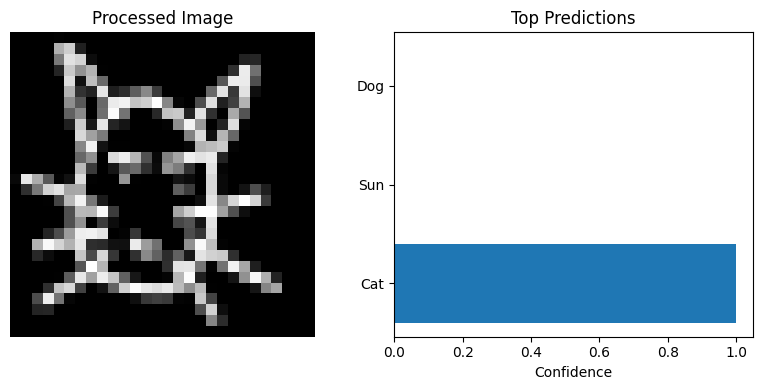


Top Predictions:
Cat: 99.92%
Sun: 0.06%
Dog: 0.02%


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess_image(image_path, show_process=False):
    """
    Process image for sketch recognition model
    The image should have black background and white foreground.
    :param image_path: Path to input image
    :param show_process: Display processing steps
    :return: Processed array ready for model prediction
    """
    # Read and convert to grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError("Image not found or invalid format")
    
    # Resize to 28x28 with anti-aliasing
    resized = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)
    
    # # Invert colors (white background to black) 
    # inverted = 255 - resized
    
    # Convert to float32 and normalize
    processed = resized / 255.0
    
    # Add channel dimension
    processed = np.expand_dims(processed, axis=-1)
    
    if show_process:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 4, 1)
        plt.imshow(img, cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(1, 4, 2)
        plt.imshow(resized, cmap='gray')
        plt.title("Resized")
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.imshow(processed.squeeze(), cmap='gray')
        plt.title("Normalized")
        plt.axis('off')
        
        plt.show()
    
    return processed

def predict_image(model, class_names, image_path, top_n=3):
    """
    Make prediction on an image
    :param model: Trained Keras model
    :param class_names: List of class names
    :param image_path: Path to image file
    :param top_n: Number of top predictions to show
    :return: Dictionary with predictions
    """
    # Preprocess image
    processed_image = preprocess_image(image_path)
    
    # Add batch dimension
    input_array = np.expand_dims(processed_image, axis=0)
    
    # Make prediction
    predictions = model.predict(input_array)[0]
    
    # Get top predictions
    top_indices = np.argsort(predictions)[-top_n:][::-1]
    top_predictions = {
        class_names[i]: float(predictions[i]) for i in top_indices
    }
    
    # Visualize results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(processed_image.squeeze(), cmap='gray')
    plt.title("Processed Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.barh(list(top_predictions.keys()), list(top_predictions.values()))
    plt.title("Top Predictions")
    plt.xlabel("Confidence")
    plt.tight_layout()
    plt.show()
    
    return top_predictions

# Example usage
if __name__ == "__main__":
    # Load your trained model
    model = tf.keras.models.load_model('model_path.h5')  # Update path
    
    # Predict on an image
    image_path = "image_path.jpg"  # Replace with your image path
    predictions = predict_image(model, class_names, image_path)
    
    print("\nTop Predictions:")
    for class_name, confidence in predictions.items():
        print(f"{class_name}: {confidence:.2%}")